In [14]:
import os
import numpy as np
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Path dataset split
dataset_path = r'D:\Dataset Aksara Optimized\Datasets_split_aksaraBatak702010'


In [15]:
# ImageDataGenerator for augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Dataset paths
train_dir = os.path.join(dataset_path, 'train')
val_dir = os.path.join(dataset_path, 'val')
test_dir = os.path.join(dataset_path, 'test')

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse'
)

Found 1330 images belonging to 19 classes.
Found 380 images belonging to 19 classes.
Found 190 images belonging to 19 classes.


In [16]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [17]:
# Load MobileNet as the base model without the classification layer
def create_model(trainable_from_layer, learning_rate):
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

    # Set trainable layers
    for layer in base_model.layers:
        layer.trainable = False
    for layer in base_model.layers[trainable_from_layer:]:
        layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(19, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


#### SKENARIO 1
mengatur layer-layer depan dari model MobileNet sebagai trainable (dapat di-train), sementara layer-layer lainnya akan di-freeze (tidak di-train). 
LR 1e-5



In [18]:
# Model 1: Train front layers (from layer 0 to 40)
model1 = create_model(trainable_from_layer=0, learning_rate=1e-5)
for layer in model1.layers[:41]:
    layer.trainable = True
model1.summary()
history1 = model1.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stopping]
)


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 64, 64, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 64, 64, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 64, 64, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 64, 64, 64)     │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 65, 65, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 32, 32, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 32, 32, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 32, 32, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 32, 32, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,248,339 (12.39 MB)

 Trainable params: 3,226,451 (12.31 MB)

 Non-trainable params: 21,888 (85.50 KB)

Epoch 1/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 50s 722ms/step - accuracy: 0.0521 - loss: 4.0411 - val_accuracy: 0.1316 - val_loss: 3.2588
Epoch 2/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 29s 675ms/step - accuracy: 0.0793 - loss: 3.4041 - val_accuracy: 0.1947 - val_loss: 2.9960
Epoch 3/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 29s 669ms/step - accuracy: 0.1508 - loss: 2.8737 - val_accuracy: 0.2289 - val_loss: 2.7626
Epoch 4/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 29s 673ms/step - accuracy: 0.2378 - loss: 2.4677 - val_accuracy: 0.2947 - val_loss: 2.4854
Epoch 5/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 32s 742ms/step - accuracy: 0.3277 - loss: 2.0767 - val_accuracy: 0.3868 - val_loss: 2.1794
Epoch 6/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 33s 767ms/step - accuracy: 0.4544 - loss: 1.7650 - val_accuracy: 0.4447 - val_loss: 1.9006
Epoch 7/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 35s 799ms/step - accuracy: 0.5467 - loss: 1.5549 - val_accuracy: 0.5053 - val_loss: 1.6308
Epoch 8/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 32s 747ms/step - accuracy: 0.5972 - loss: 1.3719 - val_accu

In [19]:
# Output training and validation accuracy and loss
train_accuracy1 = history1.history['accuracy']
val_accuracy1 = history1.history['val_accuracy']
train_loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']

print(f"Training Accuracy: {train_accuracy1[-1]:.4f}")
print(f"Validation Accuracy: {val_accuracy1[-1]:.4f}")
print(f"Training Loss: {train_loss1[-1]:.4f}")
print(f"Validation Loss: {val_loss1[-1]:.4f}")


Training Accuracy: 0.9308
Validation Accuracy: 0.9553
Training Loss: 0.2613
Validation Loss: 0.1953


#### SKENARIO 2
mengatur layer-layer belakang dari model MobileNet sebagai trainable (dapat di-train), sementara layer-layer lainnya akan di-freeze (tidak di-train). 
LR 1e-4



In [20]:
# Model 2: Train back layers (from layer 41 to end)
model2 = create_model(trainable_from_layer=41, learning_rate=1e-4)
for layer in model2.layers[41:]:
    layer.trainable = True
model2.summary()
history2 = model2.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 64, 64, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 64, 64, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 64, 64, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 64, 64, 64)     │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 65, 65, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 32, 32, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 32, 32, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 32, 32, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 32, 32, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,248,339 (12.39 MB)

 Trainable params: 2,958,355 (11.29 MB)

 Non-trainable params: 289,984 (1.11 MB)

Epoch 1/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 26s 407ms/step - accuracy: 0.2823 - loss: 2.6262 - val_accuracy: 0.6132 - val_loss: 1.3645
Epoch 2/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 18s 421ms/step - accuracy: 0.8684 - loss: 0.5146 - val_accuracy: 0.7816 - val_loss: 0.7332
Epoch 3/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 19s 423ms/step - accuracy: 0.9145 - loss: 0.2953 - val_accuracy: 0.8947 - val_loss: 0.4240
Epoch 4/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 19s 432ms/step - accuracy: 0.9503 - loss: 0.1860 - val_accuracy: 0.9342 - val_loss: 0.2182
Epoch 5/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 447ms/step - accuracy: 0.9579 - loss: 0.1444 - val_accuracy: 0.9474 - val_loss: 0.1611
Epoch 6/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 442ms/step - accuracy: 0.9679 - loss: 0.1130 - val_accuracy: 0.9632 - val_loss: 0.1054
Epoch 7/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 458ms/step - accuracy: 0.9777 - loss: 0.0890 - val_accuracy: 0.9737 - val_loss: 0.0800
Epoch 8/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 21s 479ms/step - accuracy: 0.9883 - loss: 0.0627 - val_accu

In [21]:
# Output training and validation accuracy and loss
train_accuracy2 = history2.history['accuracy']
val_accuracy2 = history2.history['val_accuracy']
train_loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

print(f"Training Accuracy: {train_accuracy2[-1]:.4f}")
print(f"Validation Accuracy: {val_accuracy2[-1]:.4f}")
print(f"Training Loss: {train_loss2[-1]:.4f}")
print(f"Validation Loss: {val_loss2[-1]:.4f}")


Training Accuracy: 0.9925
Validation Accuracy: 0.9711
Training Loss: 0.0419
Validation Loss: 0.0850


#### SKENARIO 3
mengatur layer-layer depan dan belakang dari model MobileNet sebagai trainable 
:41 akan LR = 1e-5
82: akan LR = 1e-4



In [22]:
# Skenario 3: Set layers before 41 with 1e-5 and from 41 onwards with 1e-4
model3 = create_model(trainable_from_layer=41, learning_rate=1e-4)
for layer in model3.layers[:41]:
    layer.trainable = True
    layer.learning_rate = 1e-5
for layer in model3.layers[41:]:
    layer.trainable = True
    layer.learning_rate = 1e-4

model3.summary()

# Melatih model
history3 = model3.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stopping]
)


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 64, 64, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 64, 64, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 64, 64, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 64, 64, 64)     │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 65, 65, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 32, 32, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 32, 32, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 32, 32, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 32, 32, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,248,339 (12.39 MB)

 Trainable params: 3,226,451 (12.31 MB)

 Non-trainable params: 21,888 (85.50 KB)

Epoch 1/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 44s 721ms/step - accuracy: 0.2204 - loss: 2.8605 - val_accuracy: 0.4053 - val_loss: 2.0244
Epoch 2/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 30s 695ms/step - accuracy: 0.7327 - loss: 0.8755 - val_accuracy: 0.5947 - val_loss: 1.3320
Epoch 3/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 30s 697ms/step - accuracy: 0.8951 - loss: 0.4069 - val_accuracy: 0.6816 - val_loss: 1.0150
Epoch 4/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 30s 690ms/step - accuracy: 0.9371 - loss: 0.2523 - val_accuracy: 0.8026 - val_loss: 0.6809
Epoch 5/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 30s 700ms/step - accuracy: 0.9422 - loss: 0.2063 - val_accuracy: 0.8395 - val_loss: 0.5053


In [23]:
# Output training and validation accuracy and loss
train_accuracy3 = history3.history['accuracy']
val_accuracy3 = history3.history['val_accuracy']
train_loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']

print(f"Training Accuracy: {train_accuracy3[-1]:.4f}")
print(f"Validation Accuracy: {val_accuracy3[-1]:.4f}")
print(f"Training Loss: {train_loss3[-1]:.4f}")
print(f"Validation Loss: {val_loss3[-1]:.4f}")


Training Accuracy: 0.9368
Validation Accuracy: 0.8395
Training Loss: 0.2110
Validation Loss: 0.5053


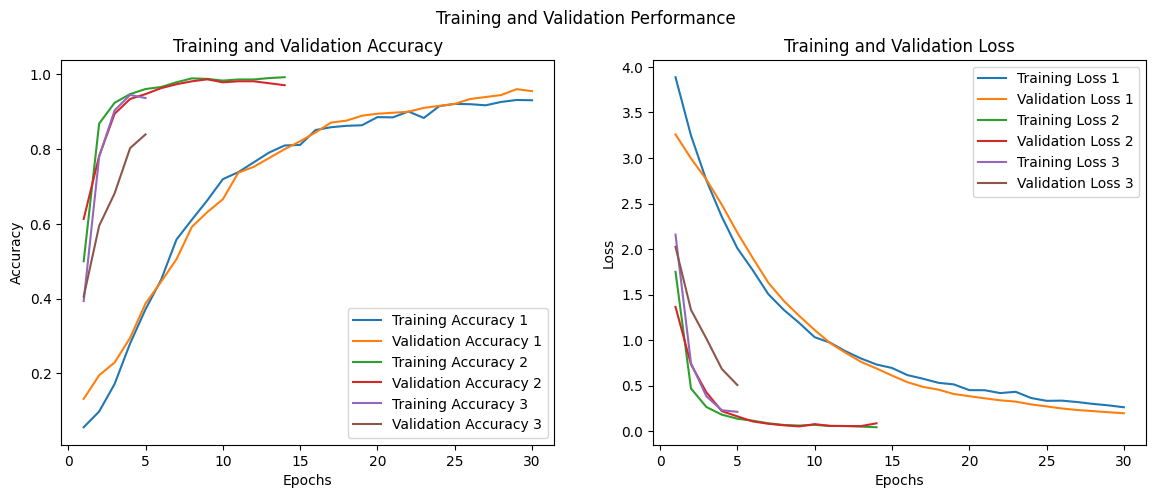

In [24]:
import matplotlib.pyplot as plt

def plot_history(histories, title):
    plt.figure(figsize=(14, 5))

    for i, history in enumerate(histories):
        epochs = range(1, len(history.history['accuracy']) + 1)
        
        plt.subplot(1, 2, 1)
        plt.plot(epochs, history.history['accuracy'], label=f'Training Accuracy {i+1}')
        plt.plot(epochs, history.history['val_accuracy'], label=f'Validation Accuracy {i+1}')
        
        plt.subplot(1, 2, 2)
        plt.plot(epochs, history.history['loss'], label=f'Training Loss {i+1}')
        plt.plot(epochs, history.history['val_loss'], label=f'Validation Loss {i+1}')

    plt.subplot(1, 2, 1)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.suptitle(title)
    plt.show()

# Memanggil fungsi plot_history dengan histories yang tersedia
plot_history([history1, history2, history3], 'Training and Validation Performance')


In [25]:
# Evaluate on test data for each model
test_loss1, test_accuracy1 = model1.evaluate(test_generator)
test_loss2, test_accuracy2 = model2.evaluate(test_generator)
test_loss3, test_accuracy3 = model3.evaluate(test_generator)

print(f"Model 1 - Test Accuracy: {test_accuracy1:.4f}, Test Loss: {test_loss1:.4f}")
print(f"Model 2 - Test Accuracy: {test_accuracy2:.4f}, Test Loss: {test_loss2:.4f}")
print(f"Model 3 - Test Accuracy: {test_accuracy3:.4f}, Test Loss: {test_loss3:.4f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.9751 - loss: 0.1494
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.9913 - loss: 0.0400
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.4641 - loss: 2.0431
Model 1 - Test Accuracy: 0.9684, Test Loss: 0.1660
Model 2 - Test Accuracy: 0.9895, Test Loss: 0.0469
Model 3 - Test Accuracy: 0.4737, Test Loss: 2.0216


#### SAVE MODEL

In [27]:
# # # Save the model
model1.save('AksaraBatakOptimizedVer2.1.h5')
model2.save('AksaraBatakOptimizedVer2.2.h5')
model3.save('AksaraBatakOptimizedVer2.3.h5')